# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [10]:
df['state_name'].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Santiago Del Estero', 'Jujuy'],
      dtype=object)

In [11]:

filtroParaElSubsetDeDatos = ['Santa Cruz', 'Río Negro', 'Neuquén', 'Tierra del Fuergo', 'Chubut']

In [12]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403 entries, 166 to 108628
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              1403 non-null   object 
 1   place_name                 1403 non-null   object 
 2   price                      1403 non-null   float64
 3   surface_covered_in_m2      1403 non-null   float64
 4   surface_not_covered_in_m2  1403 non-null   float64
 5   price_usd_per_m2           1403 non-null   float64
 6   rooms                      1403 non-null   float64
 7   lat_mediaPorZona           1403 non-null   float64
 8   lon_mediaPorZona           1403 non-null   float64
 9   pileta                     1403 non-null   int64  
 10  cochera                    1403 non-null   int64  
 11  balcon                     1403 non-null   int64  
 12  terraza                    1403 non-null   int64  
 13  parrilla             

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

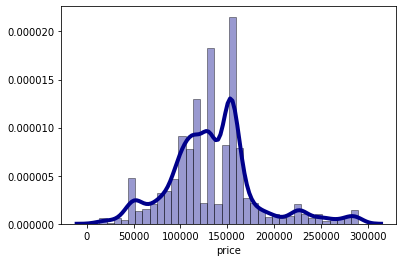

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


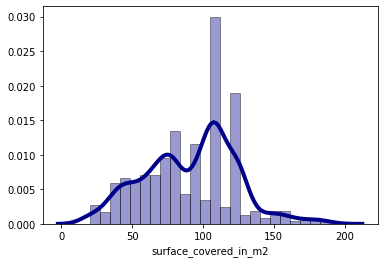

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

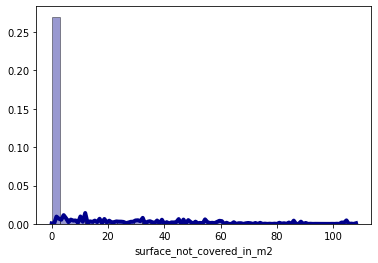

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

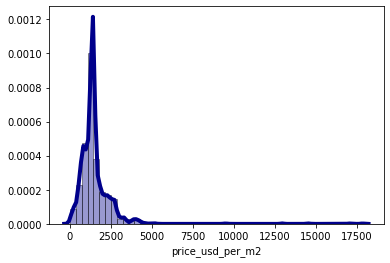

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

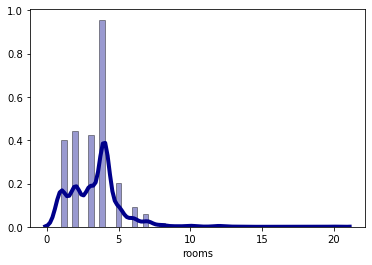

In [17]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [18]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000
mean,134113.357961,91.220594,7.006727,1511.290962,3.377049,-40.436799,-69.704381,0.035638,0.294369,0.077691,0.096935,0.107627
std,46758.510706,32.415413,17.779829,1072.222740,1.751612,1.557795,2.036335,0.185452,0.455921,0.267780,0.295975,0.310019
min,13500.000000,20.000000,0.000000,13.500000,1.000000,-51.623049,-71.645524,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109956.028571,68.353771,0.000000,1037.321024,2.000000,-41.132599,-71.346118,0.000000,0.000000,0.000000,0.000000,0.000000
50%,130942.051974,97.066667,0.000000,1398.550725,4.000000,-41.132599,-71.327997,0.000000,0.000000,0.000000,0.000000,0.000000
75%,153691.176471,108.987013,0.000000,1678.681903,4.000000,-38.952197,-68.088963,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,108.000000,17857.142857,20.000000,-31.561325,-62.994632,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 2000)

In [20]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 4)

In [21]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              903 non-null    object 
 1   place_name                 903 non-null    object 
 2   price                      903 non-null    float64
 3   surface_covered_in_m2      903 non-null    float64
 4   surface_not_covered_in_m2  903 non-null    float64
 5   price_usd_per_m2           903 non-null    float64
 6   rooms                      903 non-null    float64
 7   lat_mediaPorZona           903 non-null    float64
 8   lon_mediaPorZona           903 non-null    float64
 9   pileta                     903 non-null    int64  
 10  cochera                    903 non-null    int64  
 11  balcon                     903 non-null    int64  
 12  terraza                    903 non-null    int64  
 13  parrilla                   903 non-null    int64  

# Analizamos las variables categóricas

san carlos de bariloche    450
confluencia                113
neuquén                     63
general roca                53
lácar                       44
trelew                      23
san martín de los andes     21
chubut                      17
cipolletti                  15
villa la angostura          14
puerto madryn               11
caleta olivia               10
comodoro rivadavia           8
viedma                       8
centenario                   7
esquel                       6
trevelín                     6
rincón de los sauces         6
río negro                    6
plottier                     6
junin de los andes           5
rawson                       3
general fernández oro        3
rada tilly                   2
cinco saltos                 1
luis beltrán                 1
choele choel                 1
Name: place_name, dtype: int64


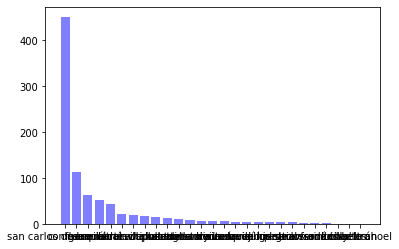

house        438
apartment    350
store         67
PH            48
Name: property_type, dtype: int64


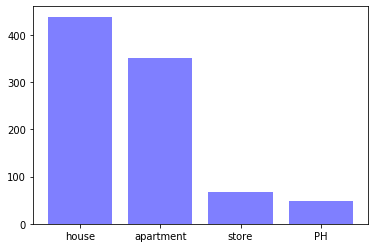

In [22]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [23]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [24]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura,property_type_apartment,property_type_house,property_type_store
0,apartment,confluencia,82664.530000,57.0,20.5,1066.639097,1.0,-38.952197,-68.088963,0,...,0,0,0,0,0,0,0,1,0,0
1,apartment,confluencia,113984.891364,77.5,0.0,1470.772792,1.0,-38.952197,-68.088963,0,...,0,0,0,0,0,0,0,1,0,0
2,apartment,general roca,51509.900657,82.0,0.0,628.169520,1.0,-38.945588,-67.780159,0,...,0,0,0,0,0,0,0,1,0,0
3,PH,san martín de los andes,130833.333333,75.0,60.0,969.135802,4.0,-40.144756,-71.327997,0,...,0,0,1,0,0,0,0,0,0,0
4,house,san martín de los andes,226352.941176,124.4,0.0,1819.557405,3.0,-40.144756,-71.327997,0,...,0,0,1,0,0,0,0,0,1,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [25]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_centenario,place_name_choele choel,place_name_chubut,place_name_cinco saltos,place_name_cipolletti,place_name_comodoro rivadavia,place_name_confluencia,place_name_esquel,place_name_general fernández oro,...,place_name_rada tilly,place_name_rawson,place_name_rincón de los sauces,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura
0,confluencia,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,general roca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,san martín de los andes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,neuquén,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,trelew,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,rada tilly,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11,san carlos de bariloche,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33,cipolletti,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,comodoro rivadavia,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,villa la angostura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Data frame auxiliar para property_type

In [26]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,apartment,1,0,0
3,PH,0,0,0
4,house,0,1,0
75,store,0,0,1


# Generamos el objeto para el K Fold

In [27]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [28]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_río negro,place_name_san carlos de bariloche,place_name_san martín de los andes,place_name_trelew,place_name_trevelín,place_name_viedma,place_name_villa la angostura,property_type_apartment,property_type_house,property_type_store
0,57.000000,20.5,1066.639097,1.0,-38.952197,-68.088963,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,77.500000,0.0,1470.772792,1.0,-38.952197,-68.088963,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,82.000000,0.0,628.169520,1.0,-38.945588,-67.780159,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,75.000000,60.0,969.135802,4.0,-40.144756,-71.327997,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,124.400000,0.0,1819.557405,3.0,-40.144756,-71.327997,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,46.000000,0.0,880.434783,3.0,-38.945588,-67.780159,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
899,122.000000,0.0,933.195574,4.0,-38.945588,-67.780159,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
900,97.625000,0.0,880.921895,2.0,-38.940071,-68.185935,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
901,97.066667,0.0,1348.990920,2.0,-41.132599,-71.346118,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0


# Generamos un modelo con Regresion Lineal

In [29]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [30]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [31]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-8.51616027e+25 -2.29389486e+26 -2.63276290e+27  3.11610826e-01
  2.48510843e-01]



Intercept: 
1261.3455446246173



Coeficientes: 
[-1.68539785e+02 -1.51949595e+02 -3.61088930e-01  9.25845850e+14
  2.00837134e+15  1.81553272e+00  6.65812446e+00  7.24894200e+00
  3.36929467e+00  3.20581205e-01 -2.99999376e+14 -1.83608045e+14
 -5.31242752e+14 -1.16897051e+14 -4.50211256e+14  2.13440709e+13
 -1.12087361e+15  1.72657662e+14 -2.70764554e+14 -8.58327513e+14
  6.87445639e+12 -1.81243692e+14  9.75945339e+13 -8.41685510e+14
 -2.69411287e+14 -4.22201033e+14  1.59737955e+13 -4.32178141e+14
 -2.89233474e+14 -5.02373977e+14  5.33086436e+14  6.78587259e+13
 -5.47534858e+14  1.93480980e+14 -6.75726041e+14  1.40383807e+14
 -1.21914074e+01  9.78861256e+00  1.79926906e+01]



MAE: 246.26424659122205
MSE: 134807.08438483
RMSE: 367.1608426627627
R2: 0.027944256078384244


In [32]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
886,836.403495,-108.381972,944.785467
467,1482.326345,1323.294884,159.031461
261,1808.965698,1532.368028,276.597670
196,1060.118171,832.805528,227.312643
260,1809.090909,1302.690025,506.400885
121,1335.325595,1254.294884,81.030711
120,1193.556700,1383.180528,-189.623828
619,804.324324,792.940025,11.384300
847,718.144634,769.805528,-51.660894
646,1348.990920,1363.805528,-14.814608


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [33]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [34]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score Ridge CV: [0.4567827  0.28312606 0.50693377 0.4448291  0.42524816]
Alpha Ridge CV: 10.0
Coeficientes:  [-1.81221463e+02 -1.64071062e+02  1.10411450e+01  4.37546095e+01
 -7.42898511e+01  5.35558089e+00  2.85544151e+00  1.10541697e+01
  9.29656929e+00  6.88391152e+00  2.54791578e+01  0.00000000e+00
 -4.12805843e+01  7.17150429e+00 -3.02997367e+01  5.48857430e+01
 -1.46363614e+01  1.98312801e+01  8.43243790e+00 -9.21887164e+01
 -1.25080161e+01 -5.09949109e+00  1.00477608e+01  3.23674664e+01
 -6.84763221e-01  6.29516264e+01  4.02056516e+01 -2.33659946e+00
 -4.31665789e+01  8.43082014e+00  5.85020387e+01  4.07306028e+01
  1.28286976e+01  7.52725392e+00 -5.56361967e-02  3.21474903e+01
 -7.92352408e+00  2.95333278e+00  3.13768427e+01]
MAE: 204.51321633670648
MSE: 94590.93084152916
RMSE: 307.55638644243624
R2: 0.1244306581761041


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
886,836.403495,-177.129901,1013.533395
467,1482.326345,1323.891936,158.434409
261,1808.965698,1526.221732,282.743965
196,1060.118171,783.111692,277.006479
260,1809.090909,1293.601676,515.489233
...,...,...,...
84,1470.772792,1286.797224,183.975567
396,566.620879,1367.271164,-800.650285
271,1299.881763,1277.364959,22.516804
584,1281.216243,1335.344734,-54.128491


# Generamos el modelo para Lasso Cross Validation

In [36]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1266.8604988231773



Coeficientes: 



[-176.67860416 -162.39926945    7.71222527   26.62947659  -88.41429758
    2.37518565    0.            8.63542571    6.98223042    5.9091464
   22.00391855    0.          -44.68597       4.39167022  -30.63194479
   45.16318339  -17.99716055   13.23475896    5.61044365  -94.67826053
  -14.27590131   -3.42170271   -0.           26.247693     -0.
   57.15174642   33.63499283    0.          -41.91839097    5.00382833
   25.64927382   30.44339322    3.18215094    0.           -0.
   21.60577593   -6.0351638     0.           26.91199501]



MAE: 204.18930176308473
MSE: 92275.68497174507
RMSE: 303.76913103826905
R2: 0.14586144741068208


In [37]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
886,836.403495,-144.579101,980.982595
467,1482.326345,1331.551438,150.774908
261,1808.965698,1515.611872,293.353825
196,1060.118171,793.612263,266.505908
260,1809.090909,1299.293404,509.797506
...,...,...,...
84,1470.772792,1295.280513,175.492279
396,566.620879,1372.251551,-805.630672
271,1299.881763,1271.140522,28.741241
584,1281.216243,1332.915418,-51.699175


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [38]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-8.51616027e+25 -2.29389486e+26 -2.63276290e+27  3.11610826e-01
  2.48510843e-01]
Score Train Ridge:  [0.4567827  0.28312606 0.50693377 0.4448291  0.42524816]
Score Train Lasso:  [0.44970088 0.28577426 0.49065285 0.44039568 0.43422386]


### Visualizamos los errores cuadraticos medios

In [39]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 367.1608426627627
Train RMSE RidgeCV: 307.55638644243624
Train RMSE Lasso: 303.76913103826905


In [40]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: 0.027944256078384244
Train R2 RidgeCV: 0.1244306581761041
Train R2 Lasso: 0.14586144741068208


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [41]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

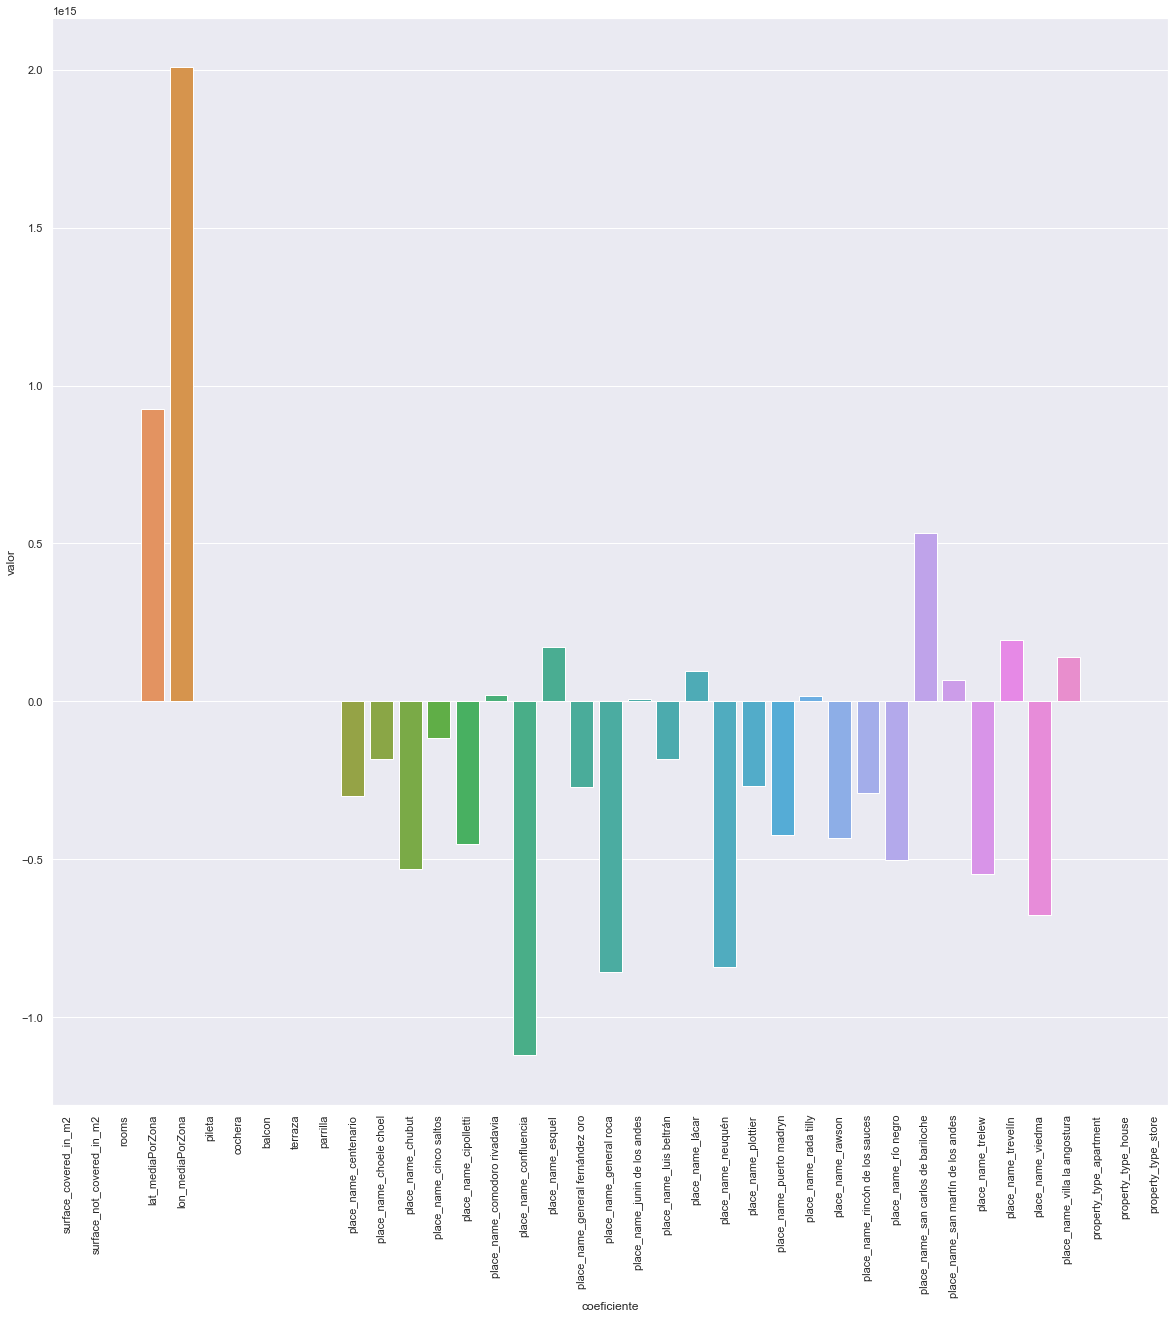

In [42]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [43]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

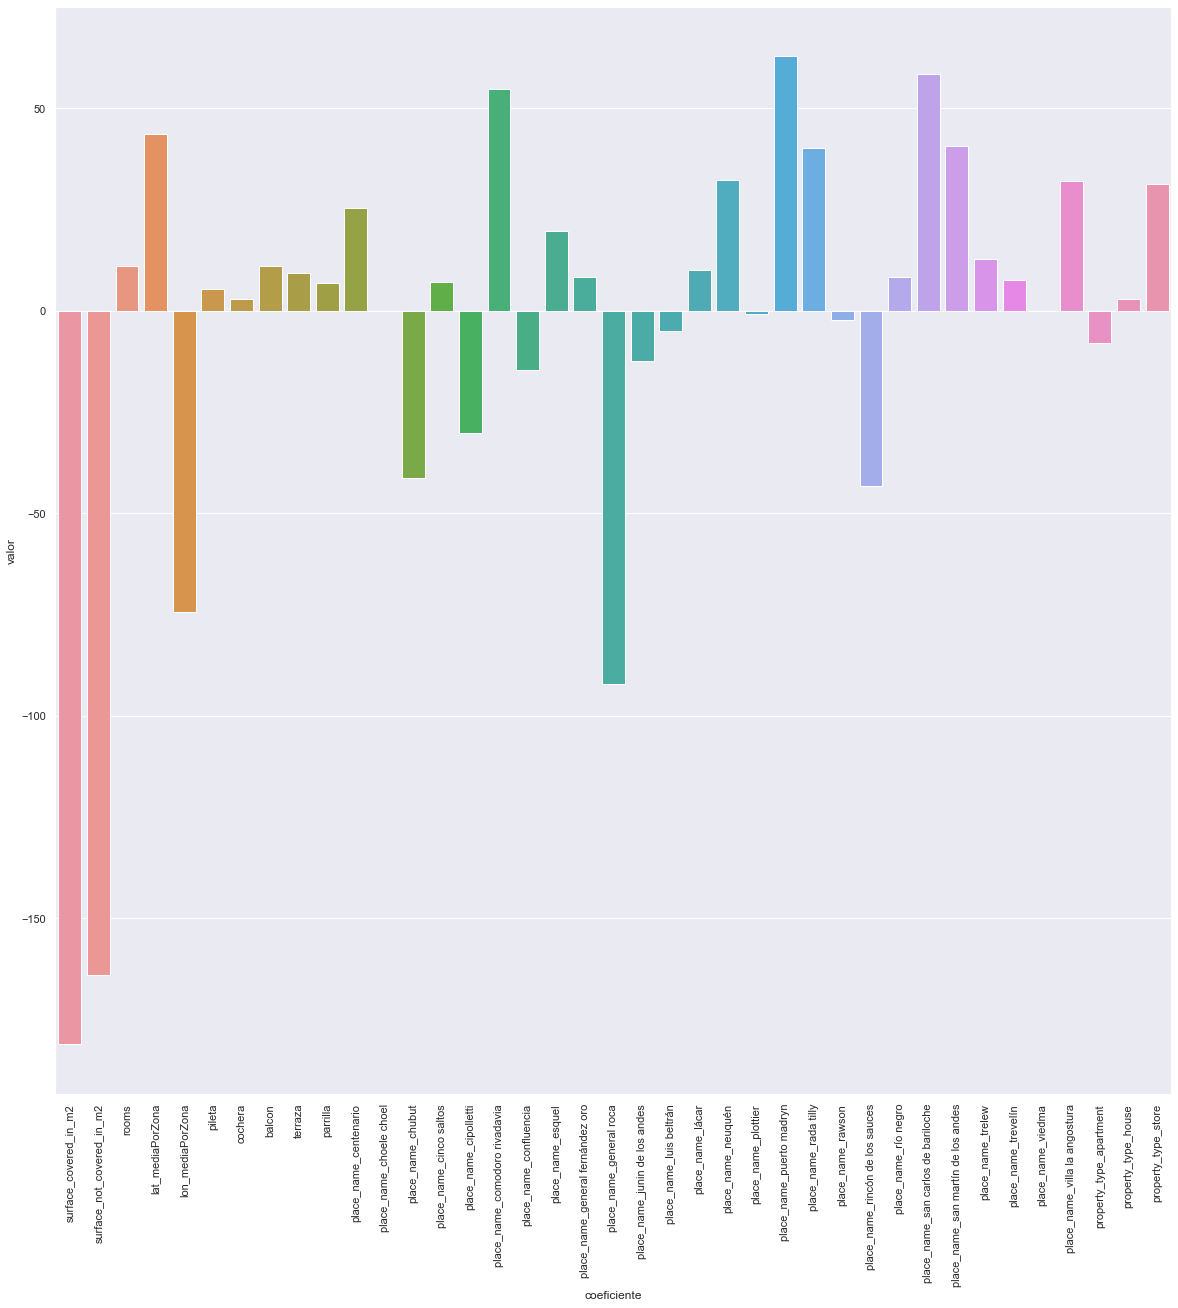

In [44]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [45]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

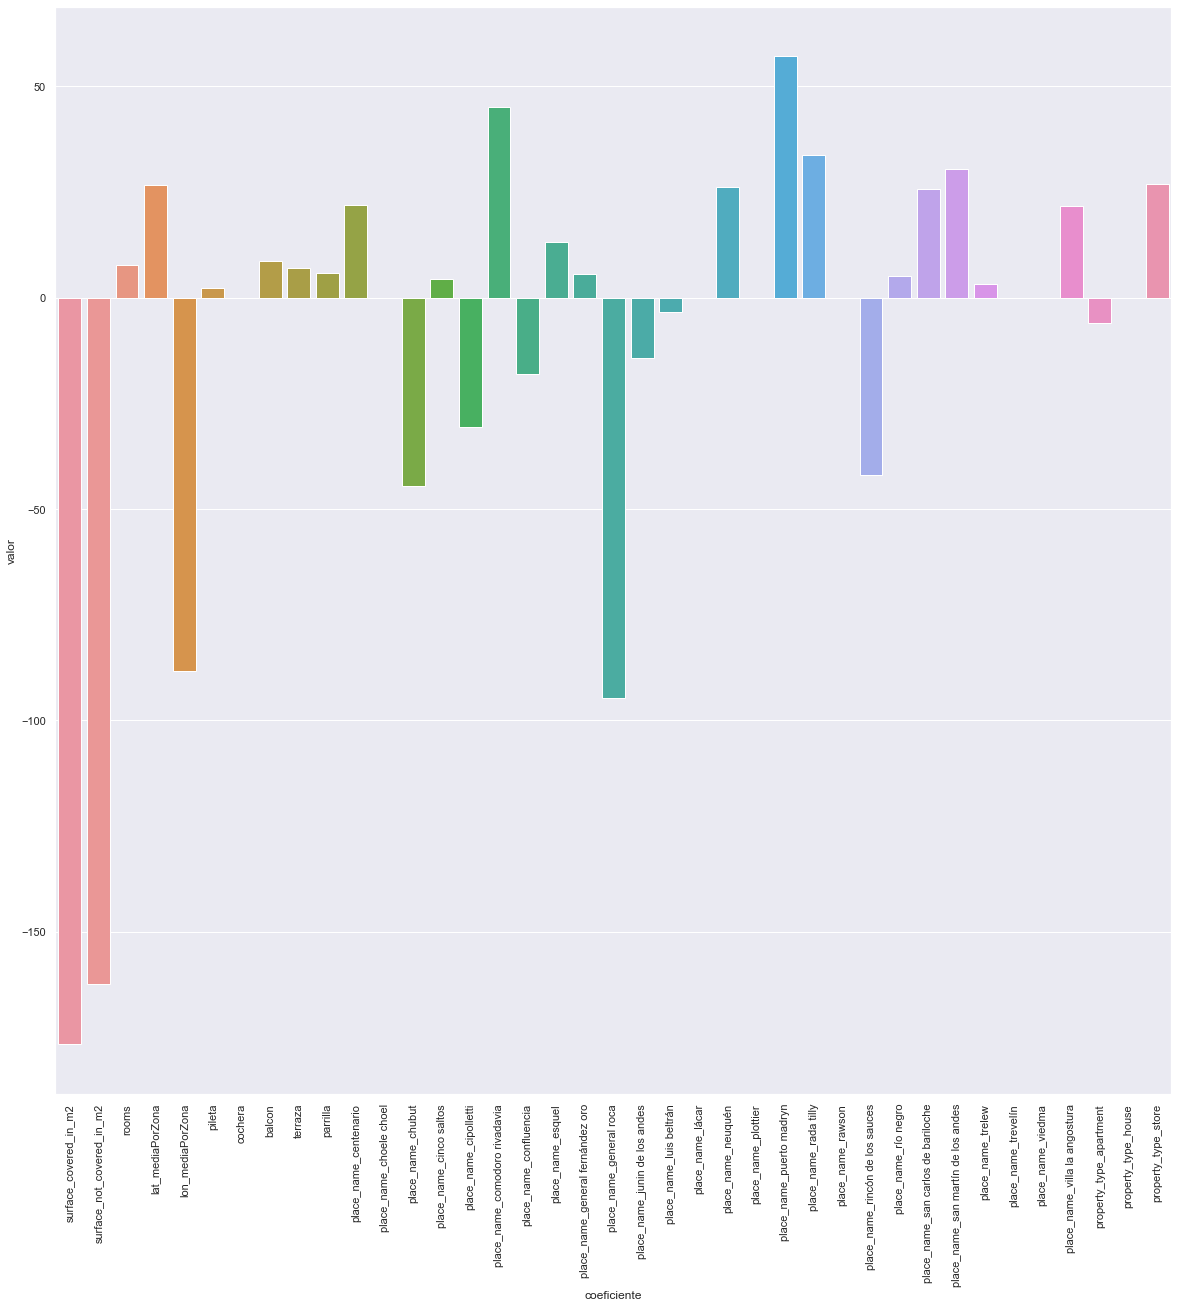

In [46]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20